# 0. Imports

In [1]:
import pandas as pd
import numpy as np
import openpyxl

from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
%matplotlib inline

from scipy.cluster.hierarchy import linkage, fcluster
from sklearn.metrics import silhouette_score

from pathlib import Path

from functions.plotting import plot_features

/var/folders/q_/pxh8rpm1021bvcmqb5qg17p00000gn/T/ipykernel_7133/521988173.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
paramsscreen = {'backend': 'ps',
            'axes.labelsize': 15,
           'legend.fontsize': 15,
           'xtick.labelsize': 13,
           'ytick.labelsize': 13,
           'axes.titlesize': 16}

plt.rcParams.update(paramsscreen)

# Define paths

In [3]:
features_path = Path("./feature_files")
feature_space_path = Path("./feature_space_files")

# 1. Load free ligand features

In [ ]:
df = pd.read_excel(features_path / "bisphosphine_lib_github_free.xlsx", "all_C2v", index_col=0, header=1, engine="openpyxl")
features = df[df.columns[1:]].loc[df.index[0:]]
features.index = features.index.astype(int)
features.dropna(axis=0, inplace=True)

features.head()

# 2. Prepare data

## 2.1. Remove colinear features

In [ ]:
cutoff = 0.95

print(f"Number of features before curation: {features.shape[1]}")
df_corr = features.corr()

df_not_correlated = ~(df_corr.mask(np.tril(np.ones([len(df_corr)]*2, dtype=bool))).abs() > cutoff).any()
un_corr_idx = df_not_correlated.loc[df_not_correlated[df_not_correlated.index] == True].index
features = features[un_corr_idx]
print(f"Number of features after curation: {features.shape[1]}")

## 2.2. Scale features

In [ ]:
scaler = StandardScaler()
scaler.fit(features)
scaled_features = scaler.transform(features)

# 3. Dimensionality reduction

## 3.1. *t*-Distributed stochastic neighbor embedding (*t*-SNE)

### 3.1.1. Run *t*-SNE

In [ ]:
tsne_reducer = TSNE(n_components=2, perplexity=40, n_iter=1000, random_state=10)
tsne_reduced_features = tsne_reducer.fit_transform(scaled_features)

### 3.1.2. Add *t*-SNE coordinates to features dataframe

In [ ]:
features['TSNE1'] = tsne_reduced_features[:, 0]
features['TSNE2'] = tsne_reduced_features[:, 1]

### 3.1.3. Plot resultant feature space

In [ ]:
plot_features.plot_tsne(features['TSNE1'], features['TSNE2'])

## 3.2. Principal component analysis (PCA)

### 3.2.1. Run PCA

In [ ]:
pca_reducer = PCA(n_components=5)
pca_reducer.fit(scaled_features)

pca_reduced_features = pca_reducer.transform(scaled_features)
pca_score = pca_reducer.explained_variance_ratio_

print(f"Total variance explained by PCs: {round(np.sum(pca_score*100), 1)}%\n")
print("Percentage of explained variance per principal component:")
for i, j in enumerate(pca_score):
    print(f"PC{i+1}     {j*100:.1f}%")

### 3.2.2. Add PCA coordinates to features dataframe

In [ ]:
features['PC1'] = pca_reduced_features[:, 0]
features['PC2'] = pca_reduced_features[:, 1]
features['PC3'] = pca_reduced_features[:, 2]
features['PC4'] = pca_reduced_features[:, 3]
features['PC5'] = pca_reduced_features[:, 4]

### 3.2.3. Plot resultant feature space

In [ ]:
plot_features.plot_pca(features['PC1'], features['PC2'])

## 3.3. Save *t*-SNE and PCA coordinates with features to a CSV file

In [ ]:
features.to_csv("features_tsne_pca.csv")

# 4. Clustering of feature space

## 4.1. Read in *t*-SNE and PCA coordinates with features

In [4]:
feature_space = pd.read_csv(feature_space_path / "features_tsne_pca.csv", index_col=0)

## 4.2. Ward clustering of *t*-SNE space

In [5]:
tsne_coordinates = feature_space[['TSNE1', 'TSNE2']]

### 4.2.1. Silhouette score

Number of clusters with max silhouette score: 8


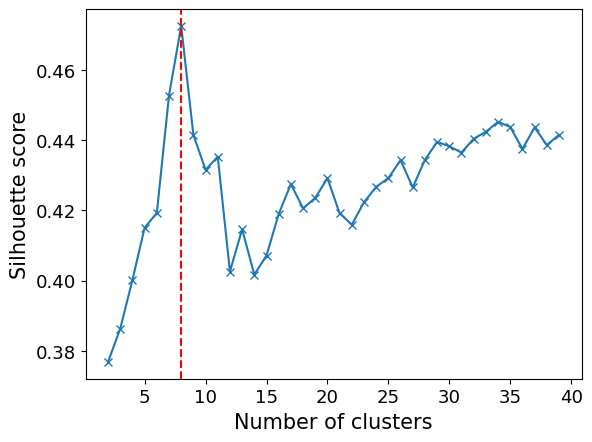

In [6]:
n_cluster = []
scores = []

range_n_clusters = range(2,40)

for i in range_n_clusters:
    n_cluster.append(i)
    z = linkage(tsne_coordinates, method='ward')
    scores.append(silhouette_score(tsne_coordinates, fcluster(z, i, criterion='maxclust')))

print(f"Number of clusters with max silhouette score: {scores.index(max(scores))+2}")

plt.plot(n_cluster, scores, 'x-')
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette score")
plt.axvline(x=scores.index(max(scores))+2, linestyle='--', color='red')
plt.show()

### 4.2.2. Cluster with defined number

In [7]:
n_clusters = 10

z = linkage(tsne_coordinates, method='ward')
cluster_assignments = fcluster(z, n_clusters, criterion='maxclust')

### 4.2.3. Add cluster assignments to features dataframe

In [8]:
feature_space['tsne_ward_clusters'] = cluster_assignments

### 4.2.4. Plot clusters on *t*-SNE feature space

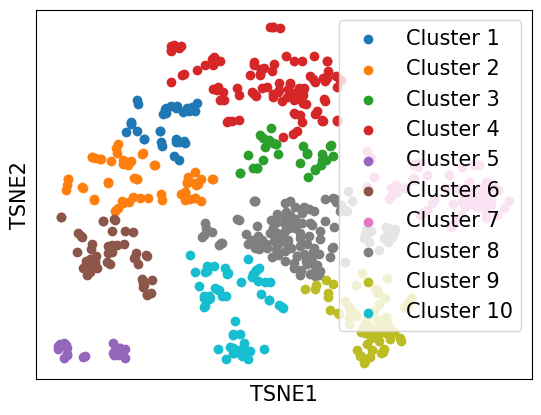

In [9]:
plot_features.plot_tsne_clusters(feature_space['TSNE1'], feature_space['TSNE2'], feature_space['tsne_ward_clusters'])

### 4.2.5. Find cluster centroids

In [10]:
from scipy.spatial.distance import cdist

ligand_ids = feature_space.index
n_nearest_ligands = 5

centers = feature_space.groupby(feature_space['tsne_ward_clusters']).mean()
centroids = []

for cluster in range(0, n_clusters):
    array = np.asarray(centers[['TSNE1', 'TSNE2']].loc[centers.index == cluster+1])
    distances = pd.DataFrame(cdist(array, tsne_coordinates)).T
    sorted_distances = distances.sort_values(0)
    sorted_distances_new = sorted_distances.rename(columns={0: "Euclidian distance"})
    sorted_distances_new["ligand_id"] = ligand_ids[sorted_distances_new.index]
    final = sorted_distances_new.set_index("ligand_id")
    centroids.append(final.index[0])
    print(f"Cluster {cluster+1}, {n_nearest_ligands} ligands nearest to cluster centroid:\n")
    print(final.head(n_nearest_ligands))
    print("---------------------------------------\n")

Cluster 1, 5 ligands nearest to cluster centroid:

           Euclidian distance
ligand_id                    
469                  1.179873
751                  1.215696
305                  1.729187
299                  1.828047
733                  2.547442
---------------------------------------

Cluster 2, 5 ligands nearest to cluster centroid:

           Euclidian distance
ligand_id                    
153                  0.396001
167                  0.396045
166                  0.736747
409                  2.763827
556                  2.814356
---------------------------------------

Cluster 3, 5 ligands nearest to cluster centroid:

           Euclidian distance
ligand_id                    
70                   1.095041
414                  1.886469
117                  2.097731
422                  2.172458
121                  2.234917
---------------------------------------

Cluster 4, 5 ligands nearest to cluster centroid:

           Euclidian distance
ligand_id    

### 4.2.6. Plot centroids on feature space

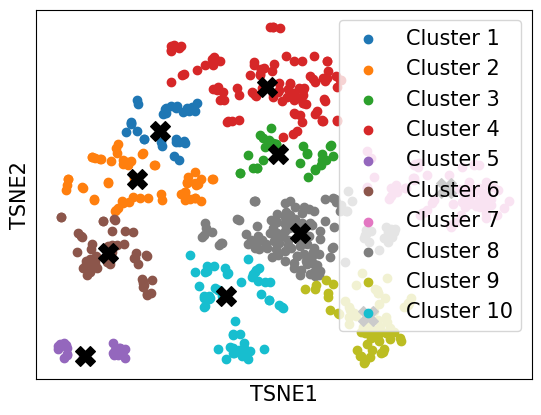

In [11]:
plot_features.plot_tsne_clusters(feature_space['TSNE1'], feature_space['TSNE2'], clusters=feature_space['tsne_ward_clusters'], centroids=centroids)

## 4.3. *k*-Means clustering of PCA space

### 4.3.1. Elbow method

In [12]:
pca_coordinates = feature_space[['PC1', 'PC2', 'PC3', 'PC4', 'PC5']]

In [13]:
from sklearn.cluster import KMeans
from autoelbow_rupakbob import autoelbow

AutoElbow number of clusters: 5


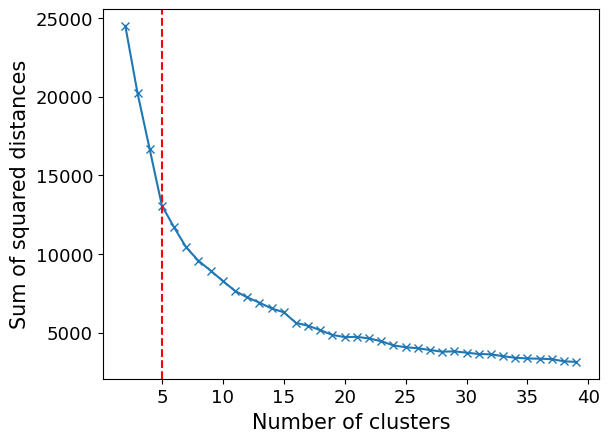

In [14]:
sum_of_squared_distances = []
K = range(2,40)

for k in K:
    km = KMeans(n_clusters=k, random_state=42)
    km = km.fit(pca_coordinates)
    sum_of_squared_distances.append(km.inertia_)

auto_elbow = autoelbow.auto_elbow_search(pca_coordinates)

print(f"AutoElbow number of clusters: {auto_elbow}")

plt.plot(K, sum_of_squared_distances, 'x-')
plt.xlabel("Number of clusters")
plt.ylabel("Sum of squared distances")
plt.axvline(x=auto_elbow, linestyle='--', color='red')
plt.show()

### 4.3.2. Cluster with defined number

In [15]:
n_clusters = 13

kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(pca_coordinates)
cluster_assignments = kmeans.labels_

### 4.2.3. Add cluster assignments to features dataframe

In [16]:
feature_space['pca_kmeans_clusters'] = cluster_assignments

### 4.2.4. Plot clusters on PCA feature space

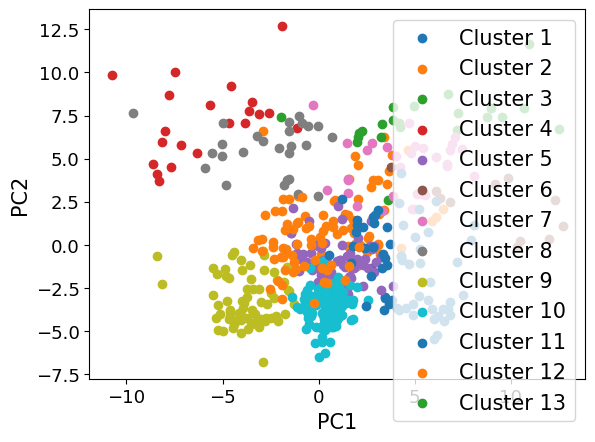

In [17]:
plot_features.plot_pca_clusters(feature_space['PC1'], feature_space['PC2'], feature_space['pca_kmeans_clusters'])

### 4.3.5. Find ligands closest to cluster centroids

In [18]:
kmeans_df = pca_coordinates.copy()

def dist_to_center(line):
    delta = line[['PC1', 'PC2', 'PC3', 'PC4', 'PC5']] - kmeans.cluster_centers_[int(line['cluster'])]
    dist = np.linalg.norm(delta)
    return(dist)

kmeans_df["closest_to_center"] = 0
kmeans_df["cluster"] = kmeans.labels_
kmeans_df["distance_to_center"] = kmeans_df.apply(dist_to_center, axis = 1)

centroids = []
for clusternumber in range(n_clusters):
    min_to_center_idx = kmeans_df[kmeans_df["cluster"] == clusternumber]["distance_to_center"].idxmin()
    centroids.append(min_to_center_idx)
    kmeans_df.loc[min_to_center_idx, "closest_to_center"] = 1

### 4.3.6. Plot centroids on feature space

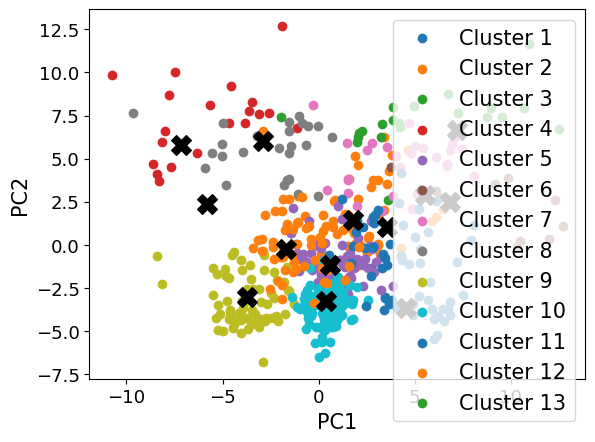

In [19]:
plot_features.plot_pca_clusters(feature_space['PC1'], feature_space['PC2'], clusters=feature_space['pca_kmeans_clusters'], centroids=centroids)

## 4.4. Save clusters to CSV file

In [20]:
feature_space.to_csv("clusters_tsne_pca.csv")

# 5. Chosen ligands in *t*-SNE and PCA feature spaces

In [22]:
chosen_ligands = [305, 480, 504, 70, 166, 382, 409, 498, 546, 584, 686, 823]

## 5.1. *t*-SNE feature space

### 5.1.1. Plot ligands

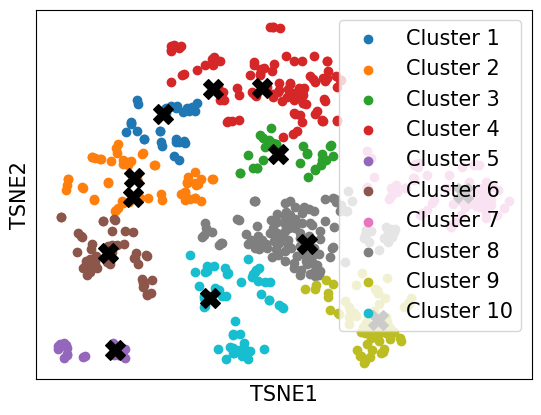

In [24]:
plot_features.plot_tsne_clusters(feature_space['TSNE1'], feature_space['TSNE2'], clusters=feature_space['tsne_ward_clusters'], centroids=chosen_ligands)

In [ ]:
# this next bit is for the paper figure - which shouldn't be included with the public version

from matplotlib import font_manager

font_dirs = ['/usr/local/share/fonts']
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)
    
# set font
plt.rcParams['font.family'] = 'Avenir LT Std, 45 Book'

figure_cluster_colors = ["#08708A", "#E38936", "#019461", "#D73A31", "#8750A3", "#8E5451", "#E3367D", "#4A6263", "#E6C300", "#56B1BF"]

n_clusters = 10 # TODO: this needs to be made unique for a tsne and pca cluster number

plt.figure(figsize=(8.5,8.5))

a = plt.gca()
xax = a.axes.get_xaxis()
xax = xax.set_visible(False)
yax = a.axes.get_yaxis()
yax = yax.set_visible(False)

for (cluster, color) in zip(range(0, n_clusters), figure_cluster_colors):
    plt.scatter(feature_space['TSNE1'].loc[feature_space['tsne_ward_clusters'] == cluster+1],
                feature_space['TSNE2'].loc[feature_space['tsne_ward_clusters'] == cluster+1],
                label=f"Cluster {cluster+1}",
                c=color,
                s=120,
                edgecolors='white',
                alpha=0.75)

for ligand in chosen_ligands:
    plt.scatter(feature_space['TSNE1'][ligand],
                feature_space['TSNE2'][ligand],
                marker='X',
                s=500,
                color='k',
                edgecolor='white')

legend = plt.legend(fontsize=13, loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=4, fancybox=True)
legend.get_frame().set_edgecolor('k')

# plt.legend(fontsize=13, loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=5, fancybox=True, shadow=True, set_edgecolor='k')

plt.savefig("tsne-for-paper.svg")

plt.show()

In [ ]:
feature_space

In [ ]:
for i in chosen_ligands:
    print(feature_space[feature_space.index == i]['tsne_ward_clusters'])

In [ ]:
listofclusters = feature_space['tsne_ward_clusters'].to_list()

In [ ]:
print(feature_space['tsne_ward_clusters'].value_counts()[1])
print(len(feature_space))

In [ ]:
for i in range(0, n_clusters):
    print(f"Cluster {i+1}")
    number_of_ligands = feature_space['tsne_ward_clusters'].value_counts()[i+1]
    total_ligands = len(feature_space)
    percentage = (number_of_ligands / total_ligands) * 100
    print(percentage)
    plt.pie([number_of_ligands, (total_ligands-number_of_ligands)])
    plt.savefig(f"pies/cluster{i+1}_pie.svg")
    plt.show()

### 5.1.2. Cluster coverage

In [ ]:
cluster_list = []

for ligand in chosen_ligands:
    cluster = feature_space['tsne_ward_clusters'][ligand]
    cluster_list.append(cluster)

plt.hist(cluster_list, bins=10)
plt.xlabel("Cluster number")
plt.ylabel("Count")
plt.xticks(np.arange(min(cluster_list), max(cluster_list)+1, 1.0))
plt.show()

## 5.2. PCA feature space

### 5.2.1. Plot ligands

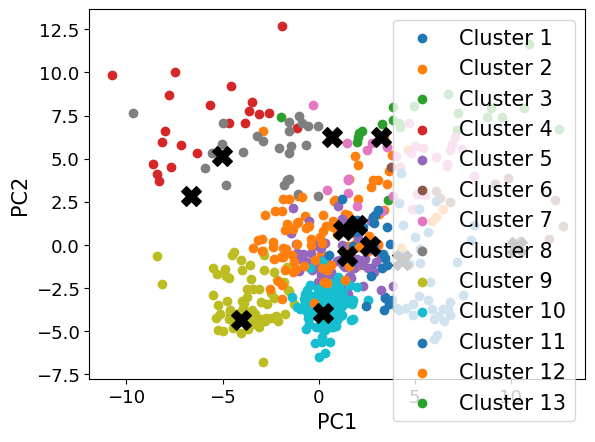

In [25]:
plot_features.plot_pca_clusters(feature_space['PC1'], feature_space['PC2'], clusters=feature_space['pca_kmeans_clusters'], centroids=chosen_ligands)

### 5.2.2. Cluster coverage

[9, 9, 12, 6, 12, 1, 7, 3, 4, 11, 10, 6]


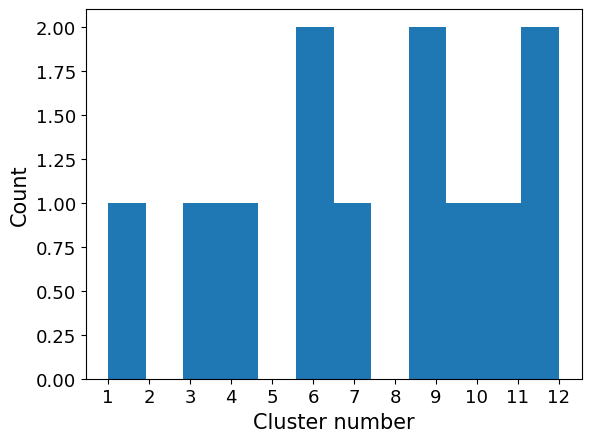

In [27]:
cluster_list = []

for ligand in chosen_ligands:
    cluster = feature_space['pca_kmeans_clusters'][ligand] + 1
    cluster_list.append(cluster)

print(cluster_list)

plt.hist(cluster_list, bins=12)
plt.xlabel("Cluster number")
plt.ylabel("Count")
plt.xticks(np.arange(min(cluster_list), max(cluster_list)+1, 1.0))
plt.show()